In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import optuna


import warnings
warnings.filterwarnings('ignore')

/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('datasets/ufc-master.csv')

Удаляем ненужные признаки

In [3]:
valuable_features = ['RedFighter',
                     'BlueFighter',                  
                     'WeightClass',
                     'Gender',
                     'Winner',
                     'Finish',
                     'NumberOfRounds',
                     'RedAge',
                     'RedHeightCms',
                     'RedReachCms',
                     'RedWeightLbs',
                     'RedStance',
                     'RedWins',
                     'RedWinsByDecisionMajority',
                     'RedWinsByDecisionSplit',
                     'RedWinsByDecisionUnanimous',
                     'RedWinsByKO',
                     'RedWinsByTKODoctorStoppage',
                     'RedWinsBySubmission',
                     'RedCurrentWinStreak',
                     'RedLosses',
                     'RedCurrentLoseStreak',
                     'RedAvgSigStrLanded',
                     'RedAvgSigStrPct',                     
                     'RedAvgSubAtt',
                     'RedAvgTDLanded',
                     'RedAvgTDPct',
                     'RedTotalRoundsFought',
                     'BlueAge',
                     'BlueHeightCms',
                     'BlueReachCms',
                     'BlueWeightLbs',
                     'BlueStance',
                     'BlueWins',
                     'BlueWinsByDecisionMajority',
                     'BlueWinsByDecisionSplit',
                     'BlueWinsByDecisionUnanimous',
                     'BlueWinsByKO',
                     'BlueWinsByTKODoctorStoppage',
                     'BlueWinsBySubmission',
                     'BlueCurrentWinStreak',
                     'BlueLosses', 
                     'BlueCurrentLoseStreak',                    
                     'BlueAvgSigStrLanded',                 # Среднее количество значимых ударов, выбрасываемых в минуту синим бойцом
                     'BlueAvgSigStrPct',                    # Соотношение значимых попаданий к общему количеству значимых ударов для синего бойца   
                     'BlueAvgSubAtt',                       # Среднее количесвто попыток болевого приема за 15 минут для синего бойца
                     'BlueAvgTDLanded',                     # Среднее количесвто тейкдаунов за 15 минут для синего бойца
                     'BlueAvgTDPct',                        # Соотношение успешных тейкдаунов к общему количеству попыток для синего бойца
                     'BlueTotalRoundsFought'
                    ]

data = data[valuable_features]

Объединяем признаки `Winner` и `Finish` в один признак `Result`

In [4]:
def def_target(row):
    if row['Winner'] == 'Red':
        if row['Finish'] == 'KO/TKO':
            return 'Red-KO/TKO'
        elif row['Finish'] == 'SUB':
            return 'Red-Submission'
        else:
            return 'Red-Decision'
    if row['Winner'] == 'Blue':
        if row['Finish'] == 'KO/TKO':
            return 'Blue-KO/TKO'
        elif row['Finish'] == 'SUB':
            return 'Blue-Submission'
        else:
            return 'Blue-Decision'
        
data['Result'] = data.apply(def_target, axis=1)

Объединим несколько признаков между собой для того, чтобы уменьшить количество признаков

In [5]:
data['RedWinsByDecision'] = data['RedWinsByDecisionMajority'] + data['RedWinsByDecisionSplit'] + data['RedWinsByDecisionUnanimous']
data['RedWinsByKO/TKO'] = data['RedWinsByKO'] + data['RedWinsByTKODoctorStoppage']

data['BlueWinsByDecision'] = data['BlueWinsByDecisionMajority'] + data['BlueWinsByDecisionSplit'] + data['BlueWinsByDecisionUnanimous']
data['BlueWinsByKO/TKO'] = data['BlueWinsByKO'] + data['BlueWinsByTKODoctorStoppage']

# Удалим лишние признаки
columns_to_drop = ['RedWinsByDecisionMajority',
                   'RedWinsByDecisionSplit',
                   'RedWinsByDecisionUnanimous',
                   'RedWinsByKO',
                   'RedWinsByTKODoctorStoppage',
                   'BlueWinsByDecisionMajority',
                   'BlueWinsByDecisionSplit',
                   'BlueWinsByDecisionUnanimous',
                   'BlueWinsByKO',
                   'BlueWinsByTKODoctorStoppage',
                   'Winner',
                   'Finish'
                   #'RedWeightLbs',
                   #'BlueWeightLbs'                          
                    ]

data = data.drop(columns=columns_to_drop, axis=1)

Бинарные и ориднильные признаки можно преобразовать в числовой вид 

In [6]:
binary_features = ['Gender', 'NumberOfRounds', 'RedStance', 'BlueStance']
data['Gender'] = data['Gender'].map({'FEMALE': 0, 'MALE': 1})
data['NumberOfRounds'] = data['NumberOfRounds'].map({3: 0, 5: 1})
data['RedStance'] = data['RedStance'].map({'Southpaw': 0, 'Orthodox': 1})
data['BlueStance'] = data['BlueStance'].map({'Southpaw': 0, 'Orthodox': 1})

ordinal_features = ['WeightClass', 'Result']
data['WeightClass'] = data['WeightClass'].map({"Women's Strawweight": 0,
                                               'Flyweight': 0,
                                               "Women's Flyweight": 0,
                                               'Bantamweight': 1,
                                               "Women's Bantamweight": 1,
                                               'Featherweight': 2,
                                               "Women's Featherweight": 2,
                                               'Catch Weight': 2,
                                               'Lightweight': 3,
                                               'Welterweight': 4,
                                               'Middleweight': 5,
                                               'Light Heavyweight': 6,
                                               'Heavyweight': 7})

data['Result'] = data['Result'].map({'Red-KO/TKO': 0,
                                     'Red-Submission': 1,
                                     'Red-Decision': 2,
                                     'Blue-KO/TKO': 3,
                                     'Blue-Submission' : 4,
                                     'Blue-Decision': 5                                     
                                    })

Бинаризуем `Result`

In [7]:
data['Result'] = data['Result'].isin([1, 3, 5]).astype(int)

Проверяем наличие пропусков

In [8]:
def check_columns_with_nans(df):
    for col in df.columns:
        isna_sum = 0
        if df[col].isna().any():
            isna_sum = df[col].isna().sum()
            print(f'{col}: {isna_sum}')

check_columns_with_nans(data)

NumberOfRounds: 21
RedStance: 375
RedAvgSigStrLanded: 455
RedAvgSigStrPct: 357
RedAvgSubAtt: 357
RedAvgTDLanded: 357
RedAvgTDPct: 367
BlueStance: 410
BlueAvgSigStrLanded: 930
BlueAvgSigStrPct: 765
BlueAvgSubAtt: 832
BlueAvgTDLanded: 833
BlueAvgTDPct: 842


In [9]:
data['NumberOfRounds'] = data['NumberOfRounds'].fillna(0)
data['RedStance'] = data['RedStance'].fillna(1)
data['BlueStance'] = data['BlueStance'].fillna(1)

Исправляем ошибки в статистических данных

In [ ]:
stats_columns = ['RedAvgSigStrLanded',
                'BlueAvgSigStrLanded',
                'RedAvgSigStrPct',
                'BlueAvgSigStrPct',
                'RedAvgSubAtt',
                'BlueAvgSubAtt',
                'RedAvgTDLanded',
                'BlueAvgTDLanded',
                'RedAvgTDPct',
                'BlueAvgTDPct'
                ]   

def stats_columns_hist(df, columns):
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 19))
    for i in range(len(columns)):
        axs[int(i // 2), i % 2].hist(df[columns[i]], bins=30)
        axs[int(i // 2), i % 2].set_title(columns[i])
        axs[int(i // 2), i % 2].grid()

stats_columns_hist(data, stats_columns)

In [21]:
def remove_rows_with_outliers(df, columns=None):
    
    # Если columns=None, выбрать все числовые столбцы
    if columns is None:
        columns = df.select_dtypes(include=['int64', 'float64']).columns    
    
    # Альтернативный способ с использованием IQR
    mask = ~df[columns].apply(lambda x:  
                                (x > (x.quantile(0.75) + 3 * (x.quantile(0.75) - x.quantile(0.25))))).any(axis=1)

    # Возвращаем датафрейм с удаленными строками, содержащими аномалии
    return mask

# (x < (x.quantile(0.25) - 3 * (x.quantile(0.75) - x.quantile(0.25)))) |

In [ ]:
stats_columns_hist(data, stats_columns)

In [ ]:
data = data.drop(columns=['RedFighter', 'BlueFighter', 'RedAvgSigStrLanded', 'BlueAvgSigStrLanded'], axis=1)
data = data.dropna()
data

In [28]:
data.to_csv('X_y_5500.csv')

### Разделяем выборку на Train и Test

In [13]:
data = data.iloc[:2000, :]

In [15]:
# X = data.drop(columns=['Result'], axis=1)
# y = data['Result']
X = data.drop(columns=['RedFighter', 'BlueFighter'])

# test_size = int(len(X)*0.2)
test_size = 200

X_train = X.iloc[test_size:, :]
# y_train = y.iloc[test_size:]

X_test = X.iloc[:test_size, :]
# y_test = y.iloc[:test_size]

In [48]:
check_columns_with_nans(X_test)

### Убираем выбросы в Train

In [49]:
# stats_columns_hist(X_test, stats_columns)

In [ ]:
stats_columns_hist(X_train, stats_columns)

In [51]:
def replace_outliers_with_nearest_quantile(df, columns): 
              
    for column_name in columns:            
        # Рассчитать первый и третий квартили
        q1 = df[column_name].quantile(0.25)
        q3 = df[column_name].quantile(0.75)
        
        # Рассчитать межквантильный диапазон (IQR)
        iqr = q3 - q1
        
        # Определить нижнюю и верхнюю границы для аномалий
        lower_bound = q1 - 3.5 * iqr
        upper_bound = q3 + 3.5 * iqr            
        
        # Заменить аномальные значения на ближайший квантиль
        df.loc[df[column_name] < lower_bound, column_name] = q1
        df.loc[df[column_name] > upper_bound, column_name] = q3
    
    return df

In [52]:
X_train = X_train[(X_train['RedAvgSigStrLanded'] < 10) & (X_train['BlueAvgSigStrLanded'] < 10)]

In [ ]:
X_train_outlines = X_train[(X_train['RedAvgSigStrLanded'] > 10) | (X_train['BlueAvgSigStrLanded'] > 10)]
X_train_outlines

In [19]:
# X_train.loc[X_train['RedAvgSigStrLanded'] > 10, 'RedAvgSigStrLanded'] = 4.13
# X_train.loc[X_train['BlueAvgSigStrLanded'] > 10, 'BlueAvgSigStrLanded'] = 4.08

In [54]:
check_columns_with_nans(X_train)

In [ ]:
X_train

In [22]:
# X_train = X_train.dropna()

### Заполняем NaN в Train

In [23]:
def replace_nan_with_median(df, columns):
    
    # Создать копию датафрейма для изменения
    df_copy = df.copy()
    
    # Заменить NaN значения на медианное значение для каждого столбца
    for column_name in columns:
        if column_name in df_copy.columns:
            median_value = df_copy[column_name].median()
            df_copy[column_name] = df_copy[column_name].fillna(median_value)
        else:
            print(f"Столбец '{column_name}' не найден в датафрейме.")
    
    return df_copy

In [24]:
# X_train = replace_nan_with_median(X_train, X_train.columns)

In [ ]:
stats_columns_hist(X_train, stats_columns)

### Обучаем модель

In [16]:
y_train = X_train['Result']
y_test = X_test['Result']

X_train = X_train.drop(columns=['Result'], axis=1)
X_test = X_test.drop(columns=['Result'], axis=1)

In [75]:
X_to_export = pd.concat([X_test.drop(columns=['RedAvgSigStrLanded', 'BlueAvgSigStrLanded'], axis=1),
                         X_train.drop(columns=['RedAvgSigStrLanded', 'BlueAvgSigStrLanded'], axis=1)],
                         axis=0)

X_to_export.to_csv('X_2000.csv')

y_to_export = pd.concat([y_test, y_train], axis=0)
y_to_export.to_csv('y_2000.csv')

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&M

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       115
           1       0.58      0.60      0.59        85

    accuracy                           0.65       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.65      0.65      0.65       200



Text(0.5, 23.52222222222222, 'predicted value')

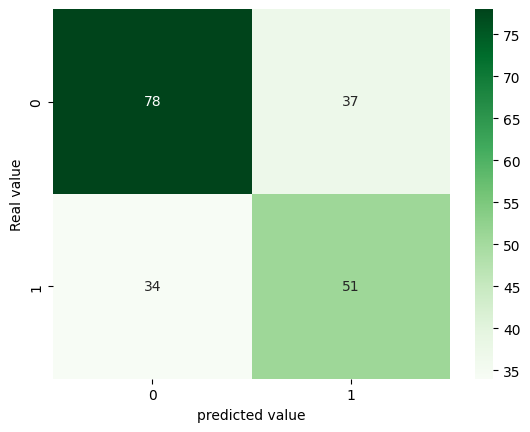

In [39]:
pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', MinMaxScaler()),
                     ('logreg', LogisticRegression(max_iter=1000))
                     ])

params = {'logreg__penalty': [None, 'l1', 'l2'],
          'logreg__C': np.linspace(0.001, 10000, 24),
          'logreg__solver': ['liblinear', 'lbfgs', 'newton-cs'],
          'logreg__class_weight': ['none', 'balanced'],
          'logreg__fit_intercept': [True, False]}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

gs_binary = GridSearchCV(estimator=pipeline, param_grid=params, cv=folds, scoring='f1', verbose=True, n_jobs=-1)

# Обучаем pipeline на тренировочных данных
gs_binary.fit(X_train, y_train)

# Делаем прогнозы на тестовых данных
y_pred = gs_binary.predict(X_test)

# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [23]:
def optimize_and_train(X_train, y_train, X_test, y_test, n_trials=20):
    # Определение пайплайна
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('logreg', LogisticRegression(max_iter=1000))
    ])

    # Определение кросс-валидации
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

    # Функция для оценки модели
    def objective(trial):
        # Определение пространства поиска гиперпараметров
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        C = trial.suggest_loguniform('C', 0.001, 10000)
        solver = trial.suggest_categorical('solver', ['liblinear'])
        class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
        fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
        
        # Установка гиперпараметров
        pipeline.set_params(
            logreg__penalty=penalty,
            logreg__C=C,
            logreg__solver=solver,
            logreg__class_weight=class_weight,
            logreg__fit_intercept=fit_intercept
        )
        
        # Кросс-валидация
        scores = cross_val_score(pipeline, X_train, y_train, cv=folds, scoring='f1')
        return scores.mean()

    # Создание и запуск оптимизатора
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Лучшие гиперпараметры
    best_params = study.best_params
    print("Best parameters:", best_params)

    # Обучаем пайплайн с лучшими гиперпараметрами
    pipeline.set_params(
        logreg__penalty=best_params['penalty'],
        logreg__C=best_params['C'],
        logreg__solver=best_params['solver'],
        logreg__class_weight=best_params['class_weight'],
        logreg__fit_intercept=best_params['fit_intercept']
    )
    pipeline.fit(X_train, y_train)

    # Делаем прогнозы на тестовых данных
    y_pred = pipeline.predict(X_test)

    # Определяем вероятности
    y_proba = pipeline.predict_proba(X_test)

    # Выводим метрики качества модели
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Матрица ошибок
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Greens')
    plt.ylabel('Real value')
    plt.xlabel('Predicted value')
    plt.show()

    return pipeline, y_pred, y_proba, pipeline

[I 2025-01-15 11:55:19,571] A new study created in memory with name: no-name-b638f500-a67e-41ea-a4e5-993d483c54eb
[I 2025-01-15 11:55:19,819] Trial 0 finished with value: 0.5823770292524371 and parameters: {'penalty': 'l1', 'C': 2.1596487743044284, 'solver': 'liblinear', 'class_weight': 'balanced', 'fit_intercept': False}. Best is trial 0 with value: 0.5823770292524371.
[I 2025-01-15 11:55:28,521] Trial 1 finished with value: 0.5680636631973979 and parameters: {'penalty': 'l1', 'C': 4775.9216974739875, 'solver': 'liblinear', 'class_weight': None, 'fit_intercept': False}. Best is trial 0 with value: 0.5823770292524371.
[I 2025-01-15 11:55:28,598] Trial 2 finished with value: 0.5365872035176217 and parameters: {'penalty': 'l1', 'C': 0.147005095397965, 'solver': 'liblinear', 'class_weight': 'balanced', 'fit_intercept': False}. Best is trial 0 with value: 0.5823770292524371.
[I 2025-01-15 11:55:28,737] Trial 3 finished with value: 0.5918640228505273 and parameters: {'penalty': 'l2', 'C': 3

Best parameters: {'penalty': 'l2', 'C': 101.72070711386527, 'solver': 'liblinear', 'class_weight': 'balanced', 'fit_intercept': True}
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       115
           1       0.57      0.59      0.58        85

    accuracy                           0.64       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.64      0.64      0.64       200



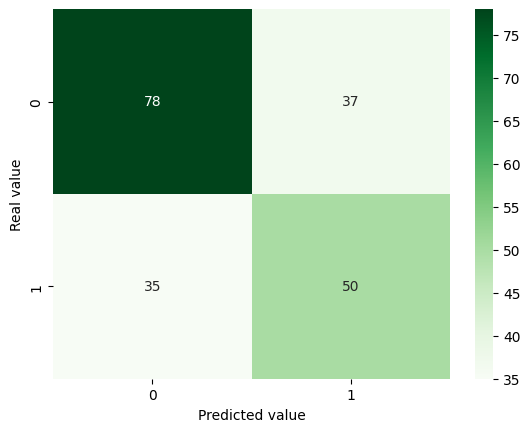

In [25]:
pipeline, y_pred, y_proba, model = optimize_and_train(X_train, y_train, X_test, y_test, n_trials=25)

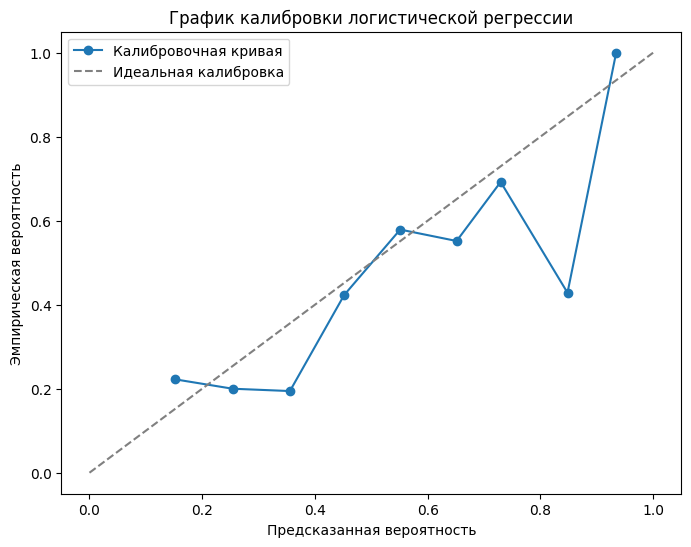

In [40]:
# # Предсказание вероятностей
y_proba = gs_binary.predict_proba(X_test)

# Создание датафрейма для хранения результатов
results_df = pd.DataFrame({
    'RedFighter': data['RedFighter'].iloc[:test_size],
    'BlueFighter': data['BlueFighter'].iloc[:test_size],
    'ProbabilityRedWins': y_proba [:, 0],
    'ProbabilityBlueWins': y_proba [:, 1],
    'ActualWinner': data['Result'].iloc[:test_size]
})


# Калибровочная кривая
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
prob_true, prob_pred = calibration_curve(y_test, y_proba_positive, n_bins=10, strategy="uniform")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Калибровочная кривая')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Эмпирическая вероятность')
plt.title('График калибровки логистической регрессии')
plt.legend()

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       115
           1       0.60      0.66      0.63        85

    accuracy                           0.67       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.67      0.67      0.67       200



Text(0.5, 23.52222222222222, 'predicted value')

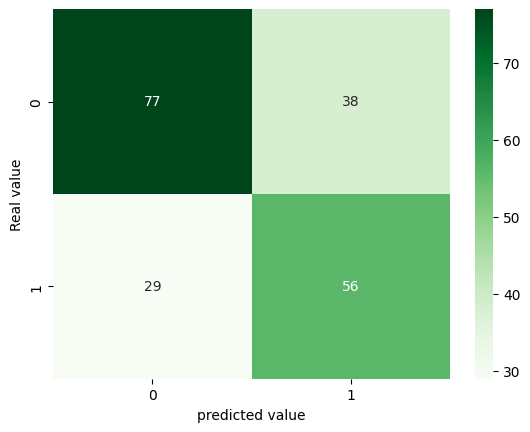

In [41]:
from sklearn.calibration import CalibratedClassifierCV

model = gs_binary.best_estimator_
# Предсказываем вероятности
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
calibrated_model.fit(X_test, y_test)
# Предсказанные вероятности после калибровки
calibrated_proba = calibrated_model.predict_proba(X_test)[:, 1]
# # Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, calibrated_proba, n_bins=10, strategy="uniform")

y_pred_calibrated = calibrated_model.predict(X_test)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred_calibrated))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred_calibrated),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### Feature Engineering

In [28]:
# Создаем новые признаки
def create_new_features(df): 
    df_copy = df.copy()   
    df_copy['Age_diff'] = df_copy['RedAge'] - df_copy['BlueAge']
    df_copy['Height_diff'] = df_copy['RedHeightCms'] - df_copy['BlueHeightCms']
    df_copy['Reach_diff'] = df_copy['RedReachCms'] - df_copy['BlueReachCms']
    df_copy['Weight_diff'] = df_copy['RedWeightLbs'] - df_copy['BlueWeightLbs']
    df_copy['Red_wins_loss_diff'] = df_copy['RedWins'] - df_copy['RedLosses']
    df_copy['Blue_wins_loss_diff'] = df_copy['BlueWins'] - df_copy['BlueLosses']
    df_copy['Red_Blue_Wins_diff'] = df_copy['RedWins'] - df_copy['BlueWins']
    df_copy['Red_Blue_Loss_diff'] = df_copy['RedLosses'] - df_copy['BlueLosses']
    # Находим разницу между числом побед-поражений для обоих бойцов
    df_copy['Red_Blue_wins_loss_diff'] = df_copy['Red_wins_loss_diff'] - df_copy['Blue_wins_loss_diff']
    return df_copy

# Находим разницу в текущих сериях побед/поражений для двух бойцов
def red_blue_streak_diff_calc(row):
    if row['RedCurrentWinStreak'] > 0: 
        if row['BlueCurrentWinStreak'] > 0:
            return row['RedCurrentWinStreak'] - row['BlueCurrentWinStreak']
        else:
            return row['RedCurrentWinStreak'] + row['BlueCurrentLoseStreak']
    else:
        if row['BlueCurrentWinStreak'] > 0:
            return -row['RedCurrentLoseStreak'] - row['BlueCurrentWinStreak']
        else:
            return -row['RedCurrentLoseStreak'] + row['BlueCurrentLoseStreak']
      
# Создаем новые признаки, касающиеся статистики бойцов
def create_new_stats_features(df):
    df_copy = df.copy() 
    df_copy['RedSigStrikesAverage'] = df_copy['RedAvgSigStrLanded'] * df_copy['RedAvgSigStrPct']
    df_copy['BlueSigStrikesAverage'] = df_copy['BlueAvgSigStrLanded'] * df_copy['BlueAvgSigStrPct']

    df_copy['RedSuccesfullTDAverage'] = df_copy['RedAvgTDLanded'] * df_copy['RedAvgTDPct']
    df_copy['BlueSuccesfullTDAverage'] = df_copy['BlueAvgTDLanded'] * df_copy['BlueAvgTDPct']

    # Найдем разницу между статистическими показателями бойцов
    df_copy['Red_Blue_SigStrikAvg_diff'] = df_copy['RedSigStrikesAverage'] - df_copy['BlueSigStrikesAverage'] 
    df_copy['Red_Blue_SuccTDAvg_diff'] = df_copy['RedSuccesfullTDAverage'] - df_copy['BlueSuccesfullTDAverage'] 
    df_copy['Red_Blue_AvgSubAtt_diff'] = df_copy['RedAvgSubAtt'] - df_copy['BlueAvgSubAtt']
    return df_copy

In [29]:
# Убираем исходные признаки и оставляем только созданные
def drop_features(df):
    df_copy = df.copy()
    df_copy = df_copy.drop(columns=[
                          'RedAge',
                          'RedHeightCms',
                          'RedReachCms',
                          'RedWeightLbs',
                          'BlueAge',
                          'BlueHeightCms',
                          'BlueReachCms',
                          'BlueWeightLbs',
                          'RedWins',
                          'RedLosses',
                          'BlueWins',
                          'BlueLosses',
                          'RedCurrentWinStreak',
                          'RedCurrentLoseStreak',
                          'RedTotalRoundsFought',
                          'BlueCurrentWinStreak',
                          'BlueCurrentLoseStreak',
                        #   'Red_wins_loss_diff',
                        #   'Blue_wins_loss_diff',                                     
                        #   'WeightClass',
                          'RedAvgSigStrLanded',
                          'RedAvgSigStrPct',
                          'BlueAvgSigStrLanded',
                          'BlueAvgSigStrPct',
                          'RedAvgTDLanded',
                          'RedAvgTDPct', 
                          'BlueAvgTDLanded',
                          'BlueAvgTDPct',
                          'RedAvgSubAtt',
                          'RedSigStrikesAverage',
                          'BlueSigStrikesAverage',
                          'RedSuccesfullTDAverage',
                          'BlueSuccesfullTDAverage',
                          'BlueAvgSubAtt',
                          'Gender',
                          'NumberOfRounds',
                          'RedWinsBySubmission',
                          'BlueWinsBySubmission',
                          'RedWinsByDecision',
                          'RedWinsByKO/TKO',
                          'BlueWinsByDecision',
                          'BlueWinsByKO/TKO',
                          'BlueTotalRoundsFought'                                    
                          ], axis=1)
    return df_copy

In [42]:
X_train_featured = create_new_features(X_train)
X_train_featured = create_new_stats_features(X_train_featured)
X_train_featured['Red_Blue_curr_streak_diff'] = X_train_featured.apply(red_blue_streak_diff_calc, axis=1)
X_train_featured = drop_features(X_train_featured)

X_test_featured = create_new_features(X_test)
X_test_featured = create_new_stats_features(X_test_featured)
X_test_featured['Red_Blue_curr_streak_diff'] = X_test_featured.apply(red_blue_streak_diff_calc, axis=1)
X_test_featured = drop_features(X_test_featured)

In [43]:
X_train_featured

,WeightClass,RedStance,BlueStance,Age_diff,Height_diff,Reach_diff,Weight_diff,Red_wins_loss_diff,Blue_wins_loss_diff,Red_Blue_Wins_diff,Red_Blue_Loss_diff,Red_Blue_wins_loss_diff,Red_Blue_SigStrikAvg_diff,Red_Blue_SuccTDAvg_diff,Red_Blue_AvgSubAtt_diff,Red_Blue_curr_streak_diff
200,1,0.0,1.0,-1,2.54,5.08,0,0,0,2,2,0,-0.7912,-0.4837,1.1,-3.0
201,0,1.0,0.0,-7,5.08,5.08,0,6,2,2,-2,4,-1.6287,1.9907,0.4,2.0
202,4,1.0,1.0,-3,2.54,2.54,0,2,0,0,-2,2,0.0104,0.0642,-2.4,1.0
203,6,1.0,1.0,-6,0.00,10.16,0,-1,-1,-1,-1,0,-1.6596,0.2208,0.2,-2.0
204,4,1.0,1.0,-6,10.16,20.32,0,1,-1,2,0,2,-3.0286,1.9400,3.9,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4,1.0,1.0,-4,5.08,0.00,0,3,4,-2,-1,-1,-0.6183,-0.4495,-0.4,2.0
1996,4,1.0,1.0,2,0.00,5.08,0,7,5,0,-2,2,-0.2289,-0.2772,0.0,8.0
1997,5,0.0,1.0,-5,-5.08,5.08,0,1,-2,-1,-4,3,0.5582,-0.6414,0.0,5.0
1998,5,0.0,1.0,2,-5.08,-5.08,0,2,2,0,0,0,-3.7110,2.5850,0.0,0.0


In [32]:
X_to_export = pd.concat([X_test_featured, X_train_featured],axis=0)

X_to_export.to_csv('X_2000_featured.csv')

# y_to_export = pd.concat([y_test, y_train], axis=0)
# y_to_export.to_csv('y_2000.csv')

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&M

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.66      0.68       115
           1       0.57      0.60      0.58        85

    accuracy                           0.64       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.64      0.64      0.64       200



Text(0.5, 23.52222222222222, 'predicted value')

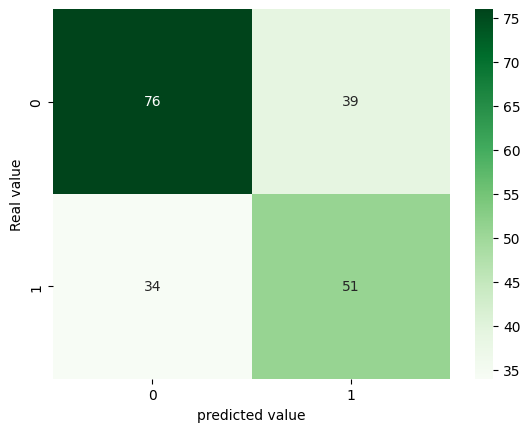

In [47]:
# Обучаем pipeline на тренировочных данных
gs_binary.fit(X_train_featured, y_train)

# Делаем прогнозы на тестовых данных
y_pred = gs_binary.predict(X_test_featured)

# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [ ]:
pipeline, y_pred, y_proba, model = optimize_and_train(X_train_featured, y_train, X_test_featured, y_test, n_trials=25)

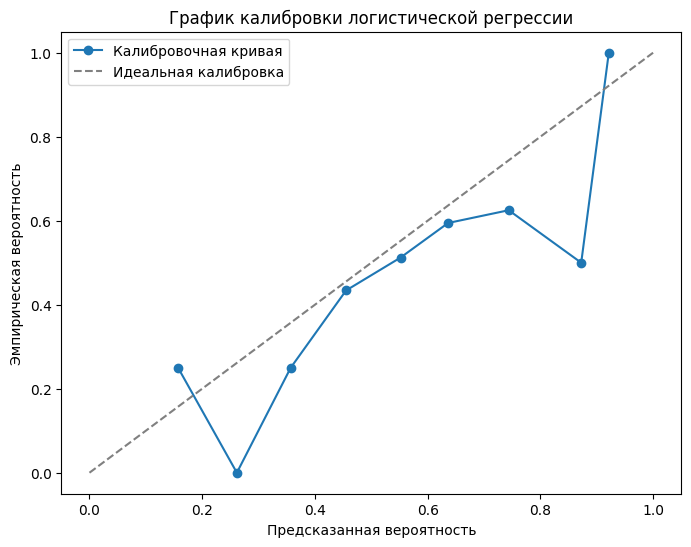

In [45]:
# Предсказание вероятностей
y_proba = gs_binary.predict_proba(X_test_featured)

# Калибровочная кривая
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
prob_true, prob_pred = calibration_curve(y_test, y_proba_positive, n_bins=10, strategy="uniform")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Калибровочная кривая')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Эмпирическая вероятность')
plt.title('График калибровки логистической регрессии')
plt.legend()

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       115
           1       0.62      0.52      0.56        85

    accuracy                           0.66       200
   macro avg       0.65      0.64      0.64       200
weighted avg       0.66      0.66      0.65       200



Text(0.5, 23.52222222222222, 'predicted value')

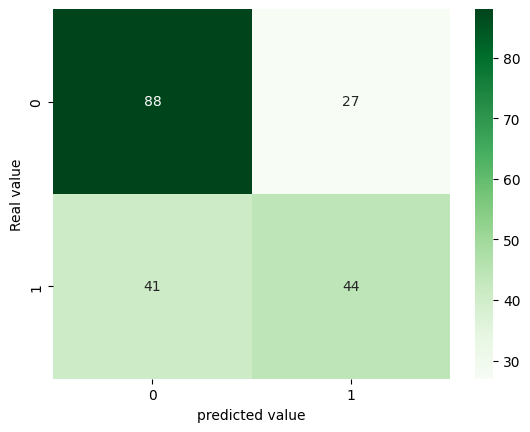

In [46]:
model = gs_binary.best_estimator_
# Предсказываем вероятности
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
calibrated_model.fit(X_test_featured, y_test)
# Предсказанные вероятности после калибровки
calibrated_proba = calibrated_model.predict_proba(X_test_featured)[:, 1]
# # Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, calibrated_proba, n_bins=10, strategy="uniform")

y_pred_calibrated = calibrated_model.predict(X_test_featured)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred_calibrated))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred_calibrated),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [ ]:
# Создание датафрейма для хранения результатов
results_df = pd.DataFrame({
    'RedFighter': data['RedFighter'].iloc[:test_size],
    'BlueFighter': data['BlueFighter'].iloc[:test_size],
    'ProbabilityRedWins': y_proba [:, 0],
    'ProbabilityBlueWins': y_proba [:, 1],
    'ActualWinner': data['Result'].iloc[:test_size]
})

results_df['Predicted_Winner'] = (results_df['ProbabilityBlueWins'] > results_df['ProbabilityRedWins']).astype(int)
results_df['Prediction_Errors'] = np.abs(results_df['Predicted_Winner'] - results_df['ActualWinner'])
results_df.iloc[:30, :]

In [35]:
featured_stats_columns = ['RedSigStrikesAverage',
                          'BlueSigStrikesAverage',
                          'RedSuccesfullTDAverage',
                          'BlueSuccesfullTDAverage',
                          'Red_Blue_SigStrikAvg_diff',
                          'Red_Blue_SuccTDAvg_diff',
                          'Red_Blue_AvgSubAtt_diff']

In [ ]:
stats_columns_hist(X_train, featured_stats_columns)